In [3]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import sys
import pdb
import glob
import matplotlib.pyplot as plt

data_dir = "./Data/Y_maze/Decision_times/"
data_target_dir = "./Data/processed_data/Y_maze/"
figure_dir = "./Figures/"


In [4]:
#experiment_type = "NoConfLowVolDTs"

plt.rcParams["figure.facecolor"] = "w"

In [5]:
col_names = ["time (ms)","event_marker","current_trial_num_in_block","block","low_rew_%","high_rew_%","low_trial_range(block)","high_trial_range(block)","block#","rewarded_trial_count","total_trial_count","sig","x_pos","y_pos","trip","chnc","current_hall","previous_hall","lick_rate_hall1","lick_rate_hall2","lick_rate_hall3","wtr","mouse_distance","TTL"]

non_action_em = [0,11,12,9,10]
left_action_em = [1,2,3,4]
right_action_em = [5,6,7,8]
rewarded_em = [1,3,5,7]
unrewarded_em = [2,4,6,8]

In [6]:
def read_raw_data(mat):
    # block, 0 = left, 1 = right
    #columns = ["time (ms)", "event_markers", "current_trial_num_in_block","block","reward_probability","conflict","volatility","block_num","rewarded","action_chosen","condition"]
    r,c = np.shape(mat[0])
    raw_df = pd.DataFrame(columns = list(np.arange(0,c,1))+["session"])

    for i in np.arange(len(mat)):
        temp = pd.DataFrame(mat[i])
        temp["session"] = i
        raw_df = raw_df.append(temp)

    return raw_df



def process_raw(raw,experiment_type):
    processed_df = pd.DataFrame(columns=["conflict","condition","volatility","event_marker","block","reward_probability","trial_length_range","session","block_num","trial_num","chosen_action","rewarded"])
    conf = experiment_type.split('Conf')[0]
    #cond = experiment_type.split('Vol')[1]
    cond = "Control" # change when stim data is here !!!!!!
    vol = experiment_type.split('Vol')[0].split('Conf')[1]
    for grp in raw_df.groupby(["session","block#","current_trial_num_in_block"]):
        temp = dict()
        temp["session"] = grp[0][0]
        temp["conflict"] = conf
        temp["volatility"] = vol
        temp["condition"] = cond
        temp["block_num"] = grp[0][1]
        temp["trial_num"] = grp[0][2]
#         time_before_iti = grp[1].loc[grp[1]["event_marker"]!=12]
#         temp["RT(ms)"] = np.max(time_before_iti["time (ms)"]) - np.min(time_before_iti["time (ms)"])
        action_em = list(set(np.unique(grp[1]["event_marker"]))-set(non_action_em))
        #print(action_em)       
        if len(action_em) == 1:
            temp["event_marker"] = action_em[0]
            if action_em[0] in left_action_em:
                temp["chosen_action"] = "left"
            elif action_em[0] in right_action_em:
                temp["chosen_action"] = "right"
            if action_em[0] in rewarded_em:
                temp["rewarded"] = "rewarded"
            elif action_em[0] in unrewarded_em:
                temp["rewarded"] = "unrewarded"
        else:
            #print("no action ems",np.unique(grp[1]["event_marker"]))
            #print(grp[0])
            temp["event_marker"] = np.nan
            temp["reward_probability"] = np.nan
            temp["chosen_action"] = np.nan
            temp["rewarded"] = np.nan

        temp["block"] = "left" if np.unique(grp[1]["block"])[0] == 0 else "right"
        temp["trial_length_range"] = str(np.unique(grp[1]["low_trial_range(block)"])[0])+"-"+str(np.unique(grp[1]["high_trial_range(block)"])[0])

        temp["reward_probability"] = str(np.unique(grp[1]["low_rew_%"])[0])+"-"+str(np.unique(grp[1]["high_rew_%"])[0])
        temp["optimal_action"] = 1 if temp["block"] == temp["chosen_action"] else 0
        processed_df = processed_df.append(temp,ignore_index=True)

    return processed_df



In [11]:
all_conflicts = pd.DataFrame()

exp_files = glob.glob(data_dir+"*.mat")
print(exp_files)
for ef in exp_files:
    print(ef)
    exp_type = ef.split('/')[-1].split('.')[0]
    exp_mat = sio.loadmat(ef)
    raw_df = read_raw_data(exp_mat['overlap'][0])
    # Replace the column numbers with the labels that Julia gave
    raw_df = raw_df.rename(columns={i:cn for i,cn in zip(np.arange(len(col_names)),col_names)})
    processed_df = process_raw(raw_df,exp_type)
    processed_df = processed_df.dropna()
    processed_df = processed_df.dropna()
    processed_df = processed_df.reset_index()

    
    rt_df = read_raw_data(exp_mat['overlap'][1])
    rt_df = rt_df.rename(columns ={0:"RT(ms)"})
    rt_df = rt_df.reset_index()
    rt_df["index"] = rt_df.index
    final_df = processed_df.merge(rt_df,on=["session","index"])
    final_df.to_csv(data_target_dir+exp_type+"_processed.csv")
    
    all_conflicts = all_conflicts.append(final_df)
    
    

['./Data/Y_maze/Decision_times/LowConfHighVolDTs.mat', './Data/Y_maze/Decision_times/HighConfHighVolDTs.mat', './Data/Y_maze/Decision_times/HighConfLowVolDTs.mat', './Data/Y_maze/Decision_times/LowConfLowVolDTs.mat', './Data/Y_maze/Decision_times/NoConfLowVolDTs.mat', './Data/Y_maze/Decision_times/NoConfHighVolDTs.mat']
./Data/Y_maze/Decision_times/LowConfHighVolDTs.mat
./Data/Y_maze/Decision_times/HighConfHighVolDTs.mat
./Data/Y_maze/Decision_times/HighConfLowVolDTs.mat
./Data/Y_maze/Decision_times/LowConfLowVolDTs.mat
./Data/Y_maze/Decision_times/NoConfLowVolDTs.mat
./Data/Y_maze/Decision_times/NoConfHighVolDTs.mat


In [15]:
all_conflicts["conflict + volatility"] = all_conflicts["conflict"]+" - "+all_conflicts["volatility"]

In [19]:
all_conflicts = all_conflicts.reset_index()

In [20]:
all_conflicts.to_csv(data_target_dir+"all_experiments_df_with_DTs.csv")


In [7]:
all_conflicts = pd.read_csv(data_target_dir+"all_experiments_df_with_DTs.csv")

In [5]:
all_conflicts

,Unnamed: 0,level_0,index,conflict,condition,volatility,event_marker,block,reward_probability,trial_length_range,session,block_num,trial_num,chosen_action,rewarded,optimal_action,RT(ms),conflict + volatility
0,0,0,0,Low,Control,High,8,left,10-90,10-20,0,1,0,right,unrewarded,0.0,606,Low - High
1,1,1,1,Low,Control,High,8,left,10-90,10-20,0,1,1,right,unrewarded,0.0,844,Low - High
2,2,2,2,Low,Control,High,1,left,10-90,10-20,0,1,2,left,rewarded,1.0,1331,Low - High
3,3,3,3,Low,Control,High,1,left,10-90,10-20,0,1,3,left,rewarded,1.0,667,Low - High
4,4,4,4,Low,Control,High,8,left,10-90,10-20,0,1,4,right,unrewarded,0.0,244,Low - High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38525,38525,5475,9326,No,Control,High,4,right,0-90,10-20,11,8,0,left,unrewarded,0.0,1348,No - High
38526,38526,5476,9327,No,Control,High,5,right,0-90,10-20,11,8,1,right,rewarded,1.0,457,No - High
38527,38527,5477,9328,No,Control,High,6,right,0-90,10-20,11,8,2,right,unrewarded,1.0,1369,No - High
38528,38528,5478,9329,No,Control,High,4,right,0-90,10-20,11,8,3,left,unrewarded,0.0,1055,No - High


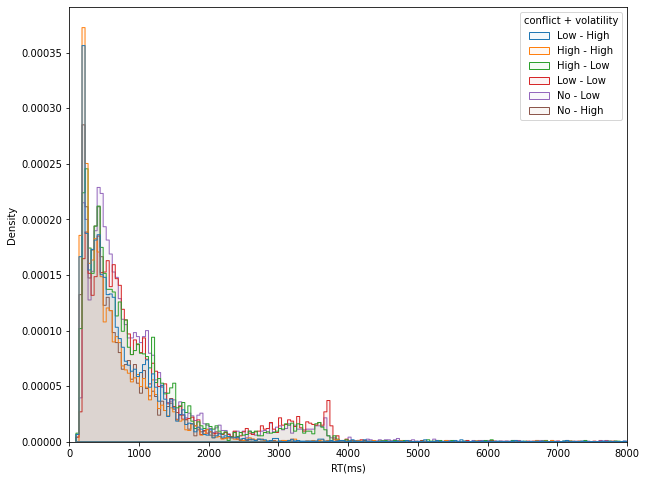

In [8]:
fig,ax = pl.subplots(1,1,figsize=(10,8))
# sns.histplot(x="RT(ms)",data=all_conflicts,hue='conflict + volatility',log_scale=True,element='step',ax=ax,kde=True,alpha=0.05,stat='density',line_kws={'linewidth':4.5})
sns.histplot(x="RT(ms)",data=all_conflicts,hue='conflict + volatility',element='step',ax=ax,alpha=0.05,stat='density',line_kws={'linewidth':4.5})
ax.set_xlim(0,8000)
fig.savefig(figure_dir+"Exanple_RT_distribution.png")

In [9]:
all_conflicts.loc[all_conflicts["RT(ms)"]==np.max(all_conflicts["RT(ms)"])]

,Unnamed: 0,level_0,index,conflict,condition,volatility,event_marker,block,reward_probability,trial_length_range,session,block_num,trial_num,chosen_action,rewarded,optimal_action,RT(ms),conflict + volatility
35381,35381,2331,2834,No,Control,High,5,right,0-90,10-20,3,14,4,right,rewarded,1.0,412079,No - High


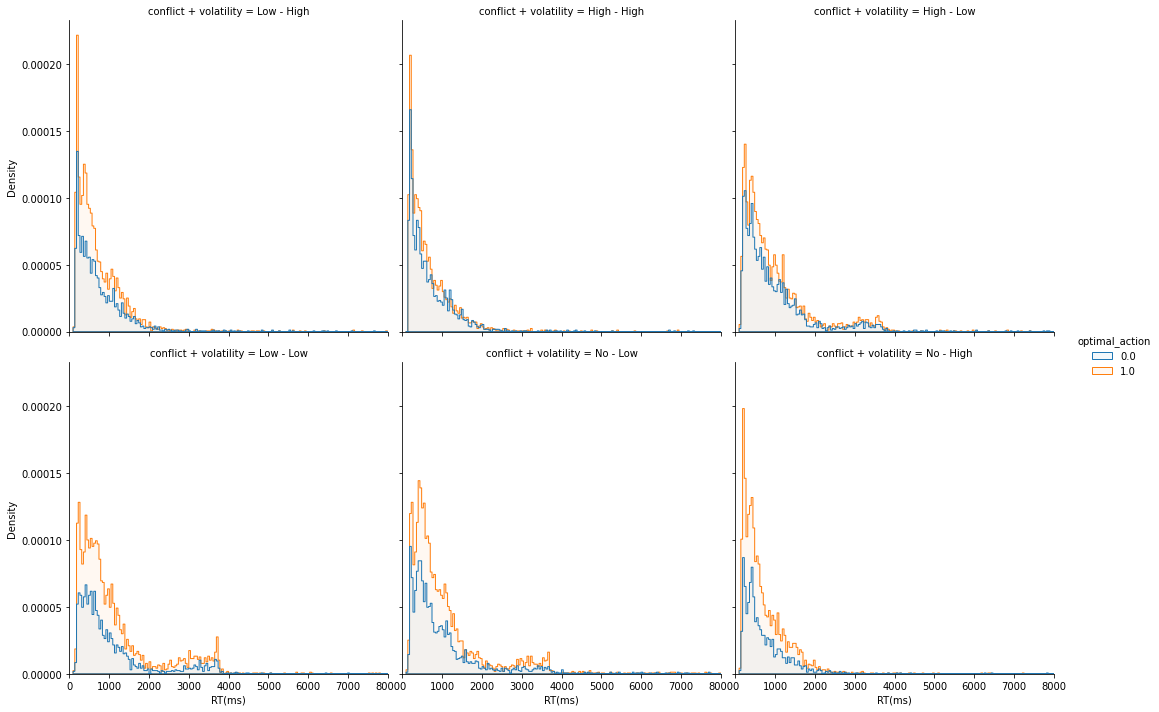

In [10]:
g2 = sns.displot(x="RT(ms)",hue="optimal_action",col='conflict + volatility',data=all_conflicts,col_wrap=3,element='step',alpha=0.05,stat='density',line_kws={'linewidth':4.5})
for ax in g2.axes:
    ax.set_xlim(0,8000)
g2.savefig(figure_dir+"Correct_vs_incorrect_action_RTs.png")

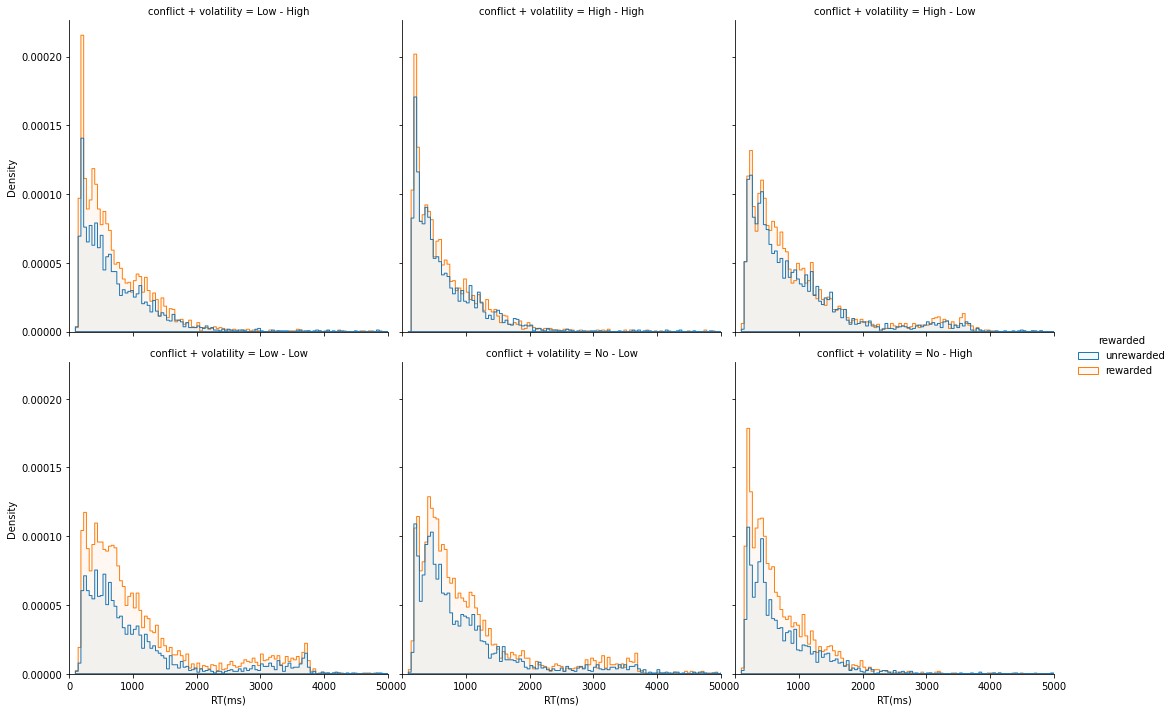

In [29]:
g3 = sns.displot(x="RT(ms)",hue="rewarded",col='conflict + volatility',data=all_conflicts,col_wrap=3,element='step',alpha=0.05,stat='density',line_kws={'linewidth':4.5})
for ax in g3.axes:
    ax.set_xlim(0,5000)

g3.savefig(figure_dir+"Rewarded_vs_unrewarded_RTs.png")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

No v.s. Low: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.815e-01 U_stat=1.614e+07
Low v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.592e-09 U_stat=1.777e+07
No v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.714e-05 U_stat=1.593e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

No v.s. Low: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.223e-03 U_stat=2.486e+07
Low v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.217e-13 U_stat=2.617e+07
No v.s. High: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.600e-05 U_stat=2.786e+07


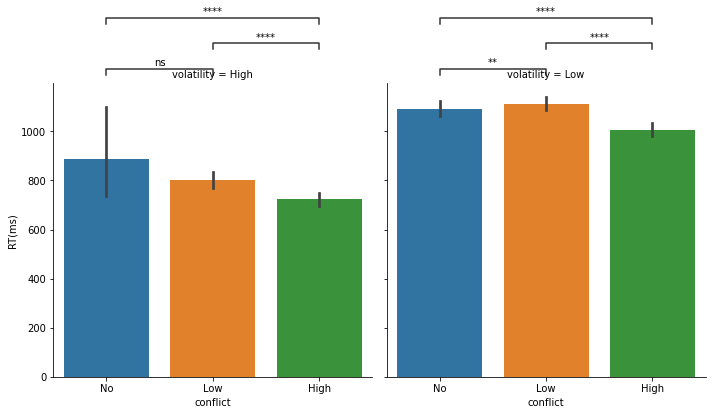

In [31]:

from statannot import add_stat_annotation


g2 = sns.catplot(x="conflict",y="RT(ms)",col='volatility',data=all_conflicts,kind='bar',order=["No","Low","High"])
for ax in g2.axes[0]:
    vol = ax.get_title().split(' = ')[1]
    add_stat_annotation(ax, data=all_conflicts.loc[all_conflicts["volatility"]==vol], x="conflict", y="RT(ms)", order=["No","Low","High"],
                    box_pairs=[("No", "Low"), ("Low", "High"), ("No", "High")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    #ax.set_yscale("log")
    
g2.savefig(figure_dir+"Correct_vs_incorrect_action_RTs_comparison.png")